<a href="https://colab.research.google.com/github/marianoogimenez/google-asl-project/blob/master/recommendation-system/collaborative-filtering/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative filtering using WALS algorithm | 3

## Train

In [0]:
PROJECT = 'qwiklabs-gcp-4a684069c4776675'
BUCKET = 'colaborative-filtering-agea'
REGION = 'us-central1'

In [0]:
import os
import shutil
from google.colab import auth
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
from tensorflow.contrib.learn.python.learn import learn_runner

In [0]:
auth.authenticate_user()

In [0]:
def read_dataset(mode, args):
  def decode_example(protos, vocab_size):
    features = {'key': tf.FixedLenFeature([1], tf.int64),
                'indices': tf.VarLenFeature(dtype=tf.int64),
                'values': tf.VarLenFeature(dtype=tf.float32)}
    parsed_features = tf.parse_single_example(protos, features)
    values = tf.sparse_merge(parsed_features['indices'], parsed_features['values'], vocab_size=vocab_size)
    # Save key to remap after batching
    # This is a temporary workaround to assign correct row numbers in each batch.
    key = parsed_features['key']
    decoded_sparse_tensor = tf.SparseTensor(indices=tf.concat([values.indices, [key]], axis = 0), values = tf.concat([values.values, [0.0]], axis = 0), dense_shape = values.dense_shape)
    return decoded_sparse_tensor
  
  
  def remap_keys(sparse_tensor):
    # Current indices of our SparseTensor that we need to fix
    bad_indices = sparse_tensor.indices
    # Current values of our SparseTensor that we need to fix
    bad_values = sparse_tensor.values 
  
    # Group by the batch_indices and get the count for each  
    size = tf.segment_sum(data = tf.ones_like(bad_indices[:,0], dtype = tf.int64), segment_ids = bad_indices[:,0]) - 1
    # The number of batch_indices (this should be batch_size unless it is a partially full batch)
    length = tf.shape(size, out_type = tf.int64)[0]
    # Finds the cumulative sum which we can use for indexing later
    cum = tf.cumsum(size)
    # The offsets between each example in the batch due to our concatentation of the keys in the decode_example method
    length_range = tf.range(start = 0, limit = length, delta = 1, dtype = tf.int64)
    # Indices of the SparseTensor's indices member of the rows we added by the concatentation of our keys in the decode_example method
    cum_range = cum + length_range

    # The keys that we have extracted back out of our concatentated SparseTensor
    gathered_indices = tf.squeeze(tf.gather(bad_indices, cum_range)[:,1])

    # The enumerated row indices of the SparseTensor's indices member
    sparse_indices_range = tf.range(tf.shape(bad_indices, out_type = tf.int64)[0], dtype = tf.int64)

    # We want to find here the row indices of the SparseTensor's indices member that are of our actual data and not the concatentated rows
    # So we want to find the intersection of the two sets and then take the opposite of that
    x = sparse_indices_range
    s = cum_range

    # Number of multiples we are going to tile x, which is our sparse_indices_range
    tile_multiples = tf.concat([tf.ones(tf.shape(tf.shape(x)), dtype=tf.int64), tf.shape(s, out_type = tf.int64)], axis = 0)
    # Expands x, our sparse_indices_range, into a rank 2 tensor and then multiplies the rows by 1 (no copying) and the columns by the number of examples in the batch
    x_tile = tf.tile(tf.expand_dims(x, -1), tile_multiples)
    # Essentially a vectorized logical or, that we then negate
    x_not_in_s = ~tf.reduce_any(tf.equal(x_tile, s), -1)

    # The SparseTensor's indices that are our actual data by using the boolean_mask we just made above applied to the entire indices member of our SparseTensor
    selected_indices = tf.boolean_mask(tensor = bad_indices, mask = x_not_in_s, axis = 0)
    # Apply the same boolean_mask to the entire values member of our SparseTensor to get the actual values data
    selected_values = tf.boolean_mask(tensor = bad_values, mask = x_not_in_s, axis = 0)

    # Need to replace the first column of our selected_indices with keys, so we first need to tile our gathered_indices
    tiling = tf.tile(input = tf.expand_dims(gathered_indices[0], -1), multiples = tf.expand_dims(size[0] , -1))
    
    # We have to repeatedly apply the tiling to each example in the batch
    # Since it is jagged we cannot use tf.map_fn due to the stacking of the TensorArray, so we have to create our own custom version
    def loop_body(i, tensor_grow):
      return i + 1, tf.concat(values = [tensor_grow, tf.tile(input = tf.expand_dims(gathered_indices[i], -1), multiples = tf.expand_dims(size[i] , -1))], axis = 0)

    _, result = tf.while_loop(lambda i, tensor_grow: i < length, loop_body, [tf.constant(1, dtype = tf.int64), tiling])
    
    # Concatenate tiled keys with the 2nd column of selected_indices
    selected_indices_fixed = tf.concat([tf.expand_dims(result, -1), tf.expand_dims(selected_indices[:, 1], -1)], axis = 1)
    
    # Combine everything together back into a SparseTensor
    remapped_sparse_tensor = tf.SparseTensor(indices = selected_indices_fixed, values = selected_values, dense_shape = sparse_tensor.dense_shape)
    return remapped_sparse_tensor

    
  def parse_tfrecords(filename, vocab_size):
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
    else:
        num_epochs = 1 # end-of-input after this
    
    files = tf.gfile.Glob(os.path.join(args['input_path'], filename))
    
    # Create dataset from file list
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(lambda x: decode_example(x, vocab_size))
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(args['batch_size'])
    dataset = dataset.map(lambda x: remap_keys(x))
    return dataset.make_one_shot_iterator().get_next()
  
  def _input_fn():
    features = {
      WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords('items_for_user', args['nitems']),
      WALSMatrixFactorization.INPUT_COLS: parse_tfrecords('users_for_item', args['nusers']),
      WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
    }
    return features, None
  
  return _input_fn

In [0]:
def find_top_k(user, item_factors, k):
  all_items = tf.matmul(tf.expand_dims(user, 0), tf.transpose(item_factors))
  topk = tf.nn.top_k(all_items, k=k)
  return tf.cast(topk.indices, dtype=tf.int64)
    
def batch_predict(args):
  with tf.Session() as sess:
    estimator = WALSMatrixFactorization(
        num_rows=args['nusers'],
        num_cols=args['nitems'],
        embedding_dimension=args['n_embeds'],
        model_dir=args['output_dir']
    )
    # this is how you would get the row factors for out-of-vocab user data
    #row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
    #user_factors = tf.convert_to_tensor(np.array(row_factors))
    
    # but for in-vocab data, the row factors are already in the checkpoint
    user_factors = tf.convert_to_tensor(estimator.get_row_factors()[0]) # (nusers, nembeds)
    # in either case, we have to assume catalog doesn't change, so col_factors are read in
    item_factors = tf.convert_to_tensor(estimator.get_col_factors()[0])# (nitems, nembeds)
    
    # for each user, find the top K items
    topk = tf.squeeze(tf.map_fn(lambda user: find_top_k(user, item_factors, args['topk']), user_factors, dtype=tf.int64))
    with file_io.FileIO(os.path.join(args['output_dir'], 'batch_pred.txt'), mode='w') as f:
      for best_items_for_user in topk.eval():
        f.write(','.join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args['num_epochs'] * args['nusers']) / args['batch_size'])
    steps_in_epoch = int(0.5 + args['nusers'] / args['batch_size'])
    print('Will train for {} steps, evaluating once every {} steps'.format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows=args['nusers'], num_cols=args['nitems'],
                embedding_dimension=args['n_embeds'],
                model_dir=args['output_dir']),
                train_input_fn=read_dataset(tf.estimator.ModeKeys.TRAIN, args),
                eval_input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args),
                train_steps=train_steps,
                eval_steps=1,
                min_eval_frequency=steps_in_epoch
        )

    
    learn_runner.run(experiment_fn, args['output_dir'])
    
    batch_predict(args)

In [0]:
shutil.rmtree('wals_trained', ignore_errors=True)
train_and_evaluate({
    'output_dir': 'wals_trained',
    'input_path': 'data/',
    'num_epochs': 0.05,
    'nitems': 5668,
    'nusers': 82802,

    'batch_size': 512,
    'n_embeds': 10,
    'topk': 3
  })

Will train for 8 steps, evaluating once every 162 steps
Instructions for updating:
Use tf.estimator.train_and_evaluate.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f56276495f8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoi

In [0]:
!ls wals_trained

batch_pred.txt				     model.ckpt-0.index
checkpoint				     model.ckpt-0.meta
eval					     model.ckpt-8.data-00000-of-00001
events.out.tfevents.1551517826.56ed76bd26cd  model.ckpt-8.index
graph.pbtxt				     model.ckpt-8.meta
model.ckpt-0.data-00000-of-00001


In [0]:
!gsutil cp wals_trained/*  gs://{BUCKET}/wals_trained   

Copying file://wals_trained/batch_pred.txt [Content-Type=text/plain]...
Copying file://wals_trained/checkpoint [Content-Type=application/octet-stream]...
Omitting directory "file://wals_trained/eval". (Did you mean to do cp -r?)
Copying file://wals_trained/events.out.tfevents.1551517826.56ed76bd26cd [Content-Type=application/octet-stream]...
Copying file://wals_trained/graph.pbtxt [Content-Type=application/octet-stream]...
- [4 files][  2.1 MiB/  2.1 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://wals_trained/model.ckpt-0.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://wals_trained/model.ckpt-0.index [Content-Type=application/octet-stream]...
Copying file://wals_trained/model.ckpt-0.meta 

In [0]:
!head wals_trained/batch_pred.txt

4491,3929,2021
5538,3689,2461
2923,2257,3599
3,1221,3116
4767,1829,5091
4231,1010,1632
1010,4577,10
7,2401,1897
5011,77,629
9,1589,560


## Get row and column factors

In [0]:
def get_factors(args):
  with tf.Session() as sess:
    estimator = WALSMatrixFactorization(
      num_rows=args['nusers'], num_cols=args['nitems'],
      embedding_dimension=args['n_embeds'],
      model_dir=args['output_dir']
    )
    row_factors = estimator.get_row_factors()[0]
    col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [0]:
args = {
    'output_dir': 'gs://{}/wals_trained'.format(BUCKET),
    'nitems': 5668,
    'nusers': 82802,
    'n_embeds': 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f562b2b5c50>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'gs://colaborative-filtering-agea/wals_trained'}
[[-4.4919419e-04 -2.1646431e-04 -2.3344136e-04  4.1561897e-04
   7.2422827e-04  1.8585239e-05  2.2978982e-04 -8.6783220e-05
   6.5142231e-05  8.0189365e-04]
 [ 7.1926607e-04  2.1249820e-04  7.7724340e

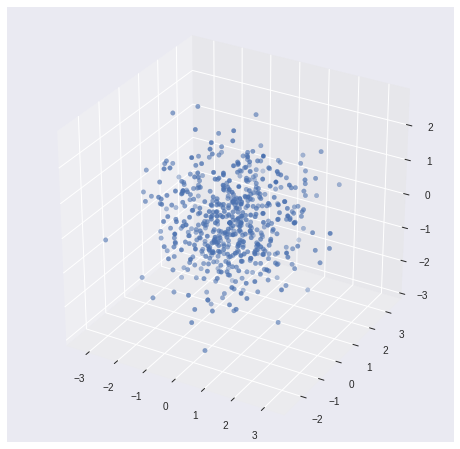

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)